## Import ibs and read data

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# Loading other necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import requests 
%matplotlib inline

#Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


np.random.seed(1001)

# load dataset
df = pd.read_csv("chronic_kidney_disease_full.csv", decimal=',')

## Data cleaning

In [2]:
#Column names were not proper strings(ex. ''age''), set proper column names.
columns = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc',
       'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv',
       'wbcc', 'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe',
       'ane', 'class']
df.columns = columns

#Some columns have character problems,to handle that; Drop corrupted '/t' characters
for clm in df.columns:
    df[clm] = df[clm].str.replace('\t','')
    df[clm] = df[clm].str.replace(' ','')

#Binary classifier unable to handle targets inputs,so replace it with a more general appearence.
df['class'] = df['class'].replace(['ckd', 'notckd'], ['yes','no'])

#Null values are displayed as questionmarks ('?').We will handle null values in this section

#Filters and drops the columns with more then %25 questionmarks(Nulls) of the all rows
freq_qmark = []
for i in columns[:-1]:
    freq_qmark.append(df[df.loc[:,i] == '?'].count()[1]/400*100)
qmark_rate = dict(zip(columns[:-1],freq_qmark))
filtered_qmark_cols = { key:value for (key,value) in qmark_rate.items() if value > 25}
df.drop(filtered_qmark_cols.keys(), axis = 1, inplace = True)

#Drop the rows with more then 7 '?' values -- 8 rows
df.drop(df[df.applymap(lambda x: str.count(x, '?')).sum(axis = 1) > 7].index, inplace = True)

#Define column types
categorical = ['sg','al','su','pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
numeric = df.columns.drop(categorical)

#Dealing with '?' values for both cathegorical and numeric columns
#Replace the missing values of categorical features with the mode of column
for column in categorical:
    df[column] = df[column].replace('?', df[column].mode()[0])
#Replace the missing values of numeric features with the mode of column
for column in numeric:
    df[column] = df[column].replace('?', 99999)
for column in numeric:
    df[column] = df[column].replace(99999, df[column].median())
    
#Because of questionmarks, csv could not handle column types, after cleaning we set column types manually    
df[numeric] = df[numeric].astype('float')
df[categorical] = df[categorical].astype('str')    

## Necessary functions

In [3]:
def prepare_inputs(df_categ):
    '''
    Function implies binary encoding of both categorical variables and target variable.
    Input: Str formatted categorical feature columns which consist 2 differenct variables
    Output: Binary form of every categorical feature.
    '''
    df_cat = df_categ.copy()
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for columner in df_cat.columns:
        df_cat[columner] = le.fit_transform(df_cat[columner])
    return df_cat

In [4]:
def correlation_matrix_constructor(df, target_column):
    '''
    Creates a correlation matrix.
    '''
    corrmat = df.corr()
    plt.figure(figsize=(20,10))
    k = 15 #number of variables for heatmap
    cols = corrmat.nlargest(k, target_column)[target_column].index
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

In [5]:
#define a cross validation calculator function
def lets_cross_validate(classifier, feature_df, target, cv, scoring):
    cv_score = cross_val_score(classifier, feature_df, target, cv=cv, scoring=scoring)
    print('Accuracy Score of each fold')
    print(cv_score)
    print("Mean Accuracy Score - " + '\033[4m'+ str(cv_score.mean()) + '\033[0m')
    return cv_score, cv_score.mean()

## Prepare Final Data

In [6]:
#Prepare categorical inputs and target as binary columns and merge with numerical columns
df_categorical = prepare_inputs(df[categorical])
df_final = pd.merge(df[numeric],df_categorical, how = 'inner', left_index = True, right_index = True)

###### Just a quick check on Multicollinearity

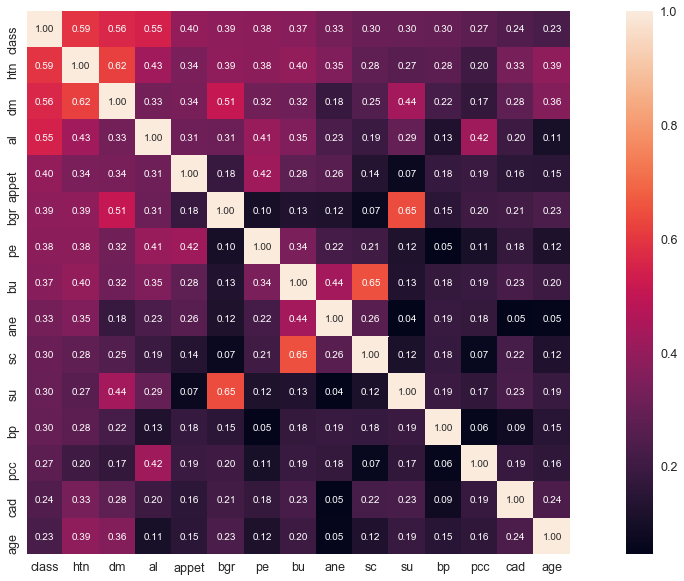

In [7]:
'''We know that ensemble methods like decision tree or random forest are immune to multicollinearity. 
However, it is still a qood idea to check it to understand feature structure'''
correlation_matrix_constructor(df_final, 'class')

#### Split target variable

In [8]:
#Lets shuffle our data
df_final = df_final.sample(frac=1)
#Create features dataframe and target array
labels = df_final['class']
df_final.drop('class', axis = 1, inplace = True)

# Lets CrossValidate

In [9]:
#define desired predictors
clf = DecisionTreeClassifier()
bgc = BaggingClassifier(base_estimator=clf, n_estimators=10, random_state=42)
rfc = RandomForestClassifier(n_estimators=10, max_features=10)
abc = AdaBoostClassifier(n_estimators=10, random_state=42)
sgb = GradientBoostingClassifier(n_estimators=10, random_state=42)

#predictors list
classifier_list = [clf,bgc,rfc,abc,sgb]

#Calculate mean cv scores and view accuracies for each fold
classifier_name = []
cv_score_list = []
mean_cvs = []
for i in classifier_list:
    print('\033[1m'+str(i)[0:str(i).find('(')]+'\033[0m')
    classifier_name.append(str(i)[0:str(i).find('(')])
    cv_scores, mean_cv = lets_cross_validate(i, df_final, labels, cv = KFold(3), scoring = 'accuracy')
    cv_score_list.append(cv_scores)
    mean_cvs.append(mean_cv)

DecisionTreeClassifier
Accuracy Score of each fold
[0.92366412 0.96183206 0.98461538]
Mean Accuracy Score - 0.9567038559404972
BaggingClassifier
Accuracy Score of each fold
[0.96183206 0.96946565 0.99230769]
Mean Accuracy Score - 0.9745351340771188
RandomForestClassifier
Accuracy Score of each fold
[0.96946565 0.97709924 1.        ]
Mean Accuracy Score - 0.9821882951653943
AdaBoostClassifier
Accuracy Score of each fold
[1.         0.99236641 1.        ]
Mean Accuracy Score - 0.9974554707379135
GradientBoostingClassifier
Accuracy Score of each fold
[0.95419847 0.96183206 1.        ]
Mean Accuracy Score - 0.9720101781170484


In [10]:
'''According to Prior cross validation results, because of its accuracy score and consistency; 
We pick RandomForestClassifier(because of high scores, it actually doesn't matter)'''

"According to Prior cross validation results, because of its accuracy score and consistency; \nWe pick RandomForestClassifier(because of high scores, it actually doesn't matter)"

## Hyper Parameter Tuning

In [11]:
'''To follow traditional train test split methodology, I used 0.30 test size, and the result is just perfect: 1.0 accuracy score.
And I just checked feature importances and everything looks normal.'''

'To follow traditional train test split methodology, I used 0.30 test size, and the result is just perfect: 1.0 accuracy score.\nAnd I just checked feature importances and everything looks normal.'

In [12]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(df_final, labels, test_size = 0.30, 
                                                    random_state = 101)

model = RandomForestClassifier(random_state= 101).fit(X_Train,Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(metrics.accuracy_score(Y_Test,predictionforest))

[[47  0]
 [ 0 71]]
1.0


In [13]:
feature_importances = pd.DataFrame(model.feature_importances_, index = X_Train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.sort_values(by = 'importance', ascending = False)

,importance
sc,0.228615
hemo,0.201320
sg,0.129798
bu,0.099065
al,0.097061
pcv,0.085548
bp,0.054959
dm,0.026829
bgr,0.013102
sod,0.012224


### Try again

In [14]:
'''However just to implement a hypertuning methodology:
I changed my test size to 0.80. Which means my randomforest will be trained by using %20 of data, 
                                                        and will be tested by using %80 of the data.
                                                        
 In Conclusion, my random search worked and my accuracy score increased from 0.949044 to 0.958598'''

'However just to implement a hypertuning methodology:\nI changed my test size to 0.80. Which means my randomforest will be trained by using %20 of data, \n                                                        and will be tested by using %80 of the data.\n                                                        \n In Conclusion, my random search worked and my accuracy score increased from 0.949044 to 0.958598'

In [15]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(df_final, labels, test_size = 0.80, 
                                                    random_state = 101)

model = RandomForestClassifier(random_state= 101).fit(X_Train,Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(metrics.accuracy_score(Y_Test,predictionforest))

[[121   0]
 [ 16 177]]
0.9490445859872612


In [16]:
feature_importances = pd.DataFrame(model.feature_importances_, index = X_Train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.sort_values(by = 'importance', ascending = False)

,importance
hemo,0.242008
sc,0.201796
al,0.133368
bu,0.130810
pcv,0.121358
bp,0.037239
sg,0.029558
age,0.023191
bgr,0.021987
sod,0.013371


## Random Search

In [18]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(5, 30, 5, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(5, 100, 5, dtype = int))}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 20, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_Train,Y_Train)


print("Random")
predictionforest = model.best_estimator_.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(metrics.accuracy_score(Y_Test,predictionforest))

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.1s


Random
[[117   4]
 [ 12 181]]
0.9490445859872612


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   10.5s finished
